In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
df_tweet = pd.read_csv("train.csv")

In [3]:
df_tweet.shape

(29992, 2)

In [4]:
def clean_text(text):
    text = text.lower()
    url = "https?://([A-z0-9_\.\-%\?&=]+/)*[A-z0-9_\.\-%\?&/=]+"
    mentions = "@[A-z0-9_\-\.%]+"
    hashtags = "#[A-z0-9_\-\.%]+"
    text = re.sub(url,"",text)
    text = re.sub(mentions,"",text)
    return text

df_tweet["tweets"] = df_tweet["tweets"].apply(clean_text)

mapper = {
    "Anxious": 0,
    "Normal": 1,
    "Stressed": 2,
    "Lonely": 3
}
df_tweet["labels"] = df_tweet["labels"].map(mapper)

### Prepare batches

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


90 th percentile is 18 words


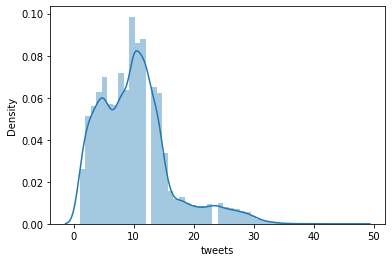

In [5]:
seq_lengths = df_tweet["tweets"].apply(lambda x: len(x.split()))

sns.distplot(seq_lengths)
print("90 th percentile is %d words"%np.quantile(seq_lengths,0.9))

In [6]:
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Bidirectional, LSTM, GRU, Dense, Dropout, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer


df_train, df_test = train_test_split(df_tweet,random_state=1,train_size=0.75)


tc = Tokenizer()

tc.fit_on_texts(list(df_train["tweets"]))

#### get number of batches
def num_batches(total,batch_size):
    if total % batch_size == 0:
        return total // batch_size
    else:
        return total // batch_size + 1

### pad and truncate     
def get_sequences(text,seq_length,tokenizer=tc):
    tokens = tokenizer.texts_to_sequences([text])
    if len(tokens[0]) < seq_length:
        pad = [0 for i in range(seq_length - len(tokens[0]))]
        pad.extend(tokens[0])
        return pad
    else:
        tokens = tokens[0][:seq_length]
        
        return tokens

def generate_batches(df, text_col, label_col, seq_length, batch_size, tokenizer=tc):
    texts = df[text_col].tolist()
    labels = df[label_col].tolist()
    cats = len(df[label_col].unique())
    total = df.shape[0]
    batches = num_batches(total,batch_size)
    while True:
    #tokens = np.array([get_sequences(t,seq_length,tc) for t in texts])
        for b in range(batches):
            if total % batch_size == 0 or b < batches - 1:
                y_batch = np.zeros((batch_size,cats))
                texts_batch = texts[b*batch_size: b*batch_size + batch_size]

                X_batch = np.array([get_sequences(t,seq_length,tc) for t in texts_batch])
                for i,l in enumerate(labels[b*batch_size: b*batch_size + batch_size]):
                    y_batch[i,l] = 1
            else:
                y_batch = np.zeros((total % batch_size,cats))
                texts_batch = texts[b*batch_size: ]

                X_batch = np.array([get_sequences(t,seq_length,tc) for t in texts_batch])
                for i,l in enumerate(labels[b*batch_size: b*batch_size + total % batch_size]):
                    y_batch[i,l] = 1
            yield X_batch,y_batch

In [7]:
len(tc.word_counts)

19375

In [8]:
train_gen = generate_batches(df_train, "tweets", "labels", 18, 120, tokenizer=tc)
val_gen = generate_batches(df_test, "tweets", "labels", 18, 120, tokenizer=tc)



### building LSTM 

In [45]:
import tensorflow as tf

metrics = tf.keras.metrics.Recall()

model = Sequential()
model.add(Embedding(19376,300,input_length=18))
model.add(LSTM(256))
model.add(Dropout(0.1))
model.add(Dense(4,activation="softmax"))

model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=metrics)

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 18, 300)           5812800   
                                                                 
 lstm_5 (LSTM)               (None, 256)               570368    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 6,384,196
Trainable params: 6,384,196
Non-trainable params: 0
_________________________________________________________________


In [46]:
steps = num_batches(df_train.shape[0],120)
val_steps = steps = num_batches(df_test.shape[0],120)
history = model.fit_generator(train_gen,validation_data=val_gen,steps_per_epoch=steps,validation_steps=val_steps,epochs=8)

Epoch 1/8


<ipython-input-46-777ede5098d4>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,validation_data=val_gen,steps_per_epoch=steps,validation_steps=val_steps,epochs=8)


63/63 [==============================] - 22s 298ms/step - loss: 1.0040 - recall_2: 0.2885 - val_loss: 0.6839 - val_recall_2: 0.5790
Epoch 2/8
63/63 [==============================] - 19s 303ms/step - loss: 0.6317 - recall_2: 0.6011 - val_loss: 0.5731 - val_recall_2: 0.6112
Epoch 3/8
63/63 [==============================] - 19s 309ms/step - loss: 0.5713 - recall_2: 0.6389 - val_loss: 0.5539 - val_recall_2: 0.6651
Epoch 4/8
63/63 [==============================] - 20s 325ms/step - loss: 0.4853 - recall_2: 0.6812 - val_loss: 0.5639 - val_recall_2: 0.6794
Epoch 5/8
63/63 [==============================] - 21s 335ms/step - loss: 0.4565 - recall_2: 0.7024 - val_loss: 0.5478 - val_recall_2: 0.6722
Epoch 6/8
63/63 [==============================] - 18s 284ms/step - loss: 0.4400 - recall_2: 0.7066 - val_loss: 0.5981 - val_recall_2: 0.6504
Epoch 7/8
63/63 [==============================] - 21s 329ms/step - loss: 0.4125 - recall_2: 0.7299 - val_loss: 0.5865 - val_recall_2: 0.6731
Epoch 8/8
63/63 

Text(0, 0.5, 'Accuracy')

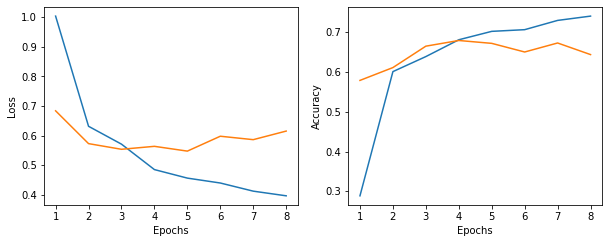

In [51]:
h = history.history
#print(h)
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(range(1,9),h["loss"])
plt.plot(range(1,9),h["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.subplot(2,2,2)
plt.plot(range(1,9),h["recall_2"])
plt.plot(range(1,9),h["val_recall_2"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

### checking for 3 epochs

In [34]:
# steps = num_batches(df_train.shape[0],120)
# val_steps = steps = num_batches(df_test.shape[0],120)
# history = model.fit_generator(train_gen,validation_data=val_gen,steps_per_epoch=steps,validation_steps=val_steps,epochs=3)

Epoch 1/3


<ipython-input-34-632cfc1472bf>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,validation_data=val_gen,steps_per_epoch=steps,validation_steps=val_steps,epochs=3)


63/63 [==============================] - 15s 185ms/step - loss: 1.0259 - categorical_accuracy: 0.5329 - val_loss: 0.6777 - val_categorical_accuracy: 0.6707
Epoch 2/3
63/63 [==============================] - 10s 165ms/step - loss: 0.6240 - categorical_accuracy: 0.6937 - val_loss: 0.5760 - val_categorical_accuracy: 0.7082
Epoch 3/3
63/63 [==============================] - 11s 175ms/step - loss: 0.5584 - categorical_accuracy: 0.7044 - val_loss: 0.5543 - val_categorical_accuracy: 0.7170


In [52]:
test_data = np.asarray(list(df_test["tweets"].apply(lambda x: get_sequences(x,18,tc))))
predictions = model.predict(test_data)
predictions = np.argmax(predictions,axis=1)

235/235 [==============================] - 9s 35ms/step


In [53]:
from sklearn.metrics import confusion_matrix, classification_report
cf = confusion_matrix(df_test["labels"],predictions)
cf

array([[1244,  135,   33,  687],
       [  74, 1855,   33,    6],
       [  52,   66, 1608,    4],
       [1182,   80,   11,  428]], dtype=int64)

In [54]:
print(classification_report(df_test["labels"],predictions))

              precision    recall  f1-score   support

           0       0.49      0.59      0.53      2099
           1       0.87      0.94      0.90      1968
           2       0.95      0.93      0.94      1730
           3       0.38      0.25      0.30      1701

    accuracy                           0.68      7498
   macro avg       0.67      0.68      0.67      7498
weighted avg       0.67      0.68      0.67      7498



### Lets try bidirectional LSTM

In [61]:
model = Sequential()
model.add(Embedding(19376,300,input_length=18))
model.add(Bidirectional(LSTM(256)))
model.add(Dropout(0.1))
model.add(Dense(4,activation="softmax"))

model.compile(optimizer="adam",loss="categorical_crossentropy",metrics="Recall")

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 18, 300)           5812800   
                                                                 
 bidirectional_4 (Bidirectio  (None, 512)              1140736   
 nal)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 4)                 2052      
                                                                 
Total params: 6,955,588
Trainable params: 6,955,588
Non-trainable params: 0
_________________________________________________________________


In [62]:
steps = num_batches(df_train.shape[0],120)
val_steps = steps = num_batches(df_test.shape[0],120)
history = model.fit_generator(train_gen,validation_data=val_gen,steps_per_epoch=steps,validation_steps=val_steps,epochs=7)

Epoch 1/7


<ipython-input-62-e375df418c4f>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,validation_data=val_gen,steps_per_epoch=steps,validation_steps=val_steps,epochs=7)


63/63 [==============================] - 47s 659ms/step - loss: 0.9644 - recall: 0.3349 - val_loss: 0.6342 - val_recall: 0.6324
Epoch 2/7
63/63 [==============================] - 35s 553ms/step - loss: 0.6227 - recall: 0.6172 - val_loss: 0.5812 - val_recall: 0.5316
Epoch 3/7
63/63 [==============================] - 33s 522ms/step - loss: 0.5716 - recall: 0.6409 - val_loss: 0.5594 - val_recall: 0.6511
Epoch 4/7
63/63 [==============================] - 35s 554ms/step - loss: 0.4807 - recall: 0.6890 - val_loss: 0.5515 - val_recall: 0.6579
Epoch 5/7
63/63 [==============================] - 33s 522ms/step - loss: 0.4554 - recall: 0.7091 - val_loss: 0.5868 - val_recall: 0.6299
Epoch 6/7
63/63 [==============================] - 35s 563ms/step - loss: 0.4414 - recall: 0.7119 - val_loss: 0.5774 - val_recall: 0.6226
Epoch 7/7
63/63 [==============================] - 35s 557ms/step - loss: 0.4102 - recall: 0.7295 - val_loss: 0.5859 - val_recall: 0.6566


{'loss': [0.9643626809120178, 0.6226750612258911, 0.5715773701667786, 0.480715274810791, 0.4553571939468384, 0.44139188528060913, 0.4101586639881134], 'recall': [0.33493462204933167, 0.6171957850456238, 0.6408730149269104, 0.6889511346817017, 0.7091270089149475, 0.711904764175415, 0.7295169234275818], 'val_loss': [0.6342123746871948, 0.5812336802482605, 0.5593910217285156, 0.5514724254608154, 0.5868409276008606, 0.5773736238479614, 0.5859479308128357], 'val_recall': [0.6324353218078613, 0.5316084027290344, 0.6511069536209106, 0.6579087972640991, 0.6299012899398804, 0.6225660443305969, 0.656575083732605]}


Text(0, 0.5, 'Accuracy')

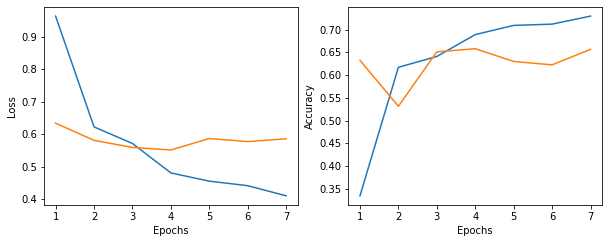

In [67]:
h = history.history
print(h)
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(range(1,8),h["loss"])
plt.plot(range(1,8),h["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.subplot(2,2,2)
plt.plot(range(1,8),h["recall"])
plt.plot(range(1,8),h["val_recall"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [68]:
# steps = num_batches(df_train.shape[0],120)
# val_steps = steps = num_batches(df_test.shape[0],120)
# history = model.fit_generator(train_gen,validation_data=val_gen,steps_per_epoch=steps,validation_steps=val_steps,epochs=3)

### Evaluate BiLSTM

In [69]:
predictions = model.predict(test_data)
predictions = np.argmax(predictions,axis=1)
cf = confusion_matrix(df_test["labels"],predictions)
cf

235/235 [==============================] - 18s 66ms/step


array([[1434,   51,   29,  585],
       [ 107, 1712,   33,  116],
       [  56,   48, 1615,   11],
       [1281,   19,    9,  392]], dtype=int64)

In [71]:
print(classification_report(df_test["labels"],predictions))

              precision    recall  f1-score   support

           0       0.50      0.68      0.58      2099
           1       0.94      0.87      0.90      1968
           2       0.96      0.93      0.95      1730
           3       0.36      0.23      0.28      1701

    accuracy                           0.69      7498
   macro avg       0.69      0.68      0.68      7498
weighted avg       0.69      0.69      0.68      7498



### Let us check GRU

In [93]:
model = Sequential()
model.add(Embedding(19376,300,input_length=18))
model.add(GRU(256))
model.add(Dropout(0.1))
model.add(Dense(4,activation="softmax"))

model.compile(optimizer="adam",loss="categorical_crossentropy",metrics="Recall")

model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 18, 300)           5812800   
                                                                 
 gru_5 (GRU)                 (None, 256)               428544    
                                                                 
 dropout_15 (Dropout)        (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 6,242,372
Trainable params: 6,242,372
Non-trainable params: 0
_________________________________________________________________


In [94]:
history = model.fit_generator(train_gen,steps_per_epoch=steps,validation_data=val_gen,validation_steps=val_steps,epochs=8)

Epoch 1/8


<ipython-input-94-c3729c0d34da>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,steps_per_epoch=steps,validation_data=val_gen,validation_steps=val_steps,epochs=8)


63/63 [==============================] - 22s 290ms/step - loss: 0.9586 - recall: 0.3336 - val_loss: 0.6376 - val_recall: 0.6362
Epoch 2/8
63/63 [==============================] - 20s 320ms/step - loss: 0.6045 - recall: 0.6326 - val_loss: 0.5825 - val_recall: 0.6124
Epoch 3/8
63/63 [==============================] - 21s 339ms/step - loss: 0.5835 - recall: 0.6434 - val_loss: 0.5613 - val_recall: 0.6754
Epoch 4/8
63/63 [==============================] - 24s 383ms/step - loss: 0.4914 - recall: 0.6828 - val_loss: 0.5646 - val_recall: 0.6715
Epoch 5/8
63/63 [==============================] - 22s 348ms/step - loss: 0.4490 - recall: 0.7134 - val_loss: 0.5593 - val_recall: 0.6426
Epoch 6/8
63/63 [==============================] - 21s 332ms/step - loss: 0.4482 - recall: 0.7205 - val_loss: 0.5730 - val_recall: 0.6923
Epoch 7/8
63/63 [==============================] - 20s 311ms/step - loss: 0.4251 - recall: 0.7296 - val_loss: 0.5826 - val_recall: 0.6675
Epoch 8/8
63/63 [===========================

Text(0, 0.5, 'categorical accuracy')

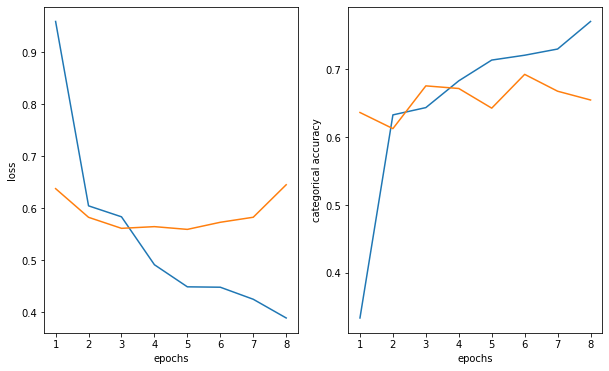

In [95]:
h = history.history
plt.figure(figsize=(10,6))
epochs = [i for i in range(1,9)]
plt.subplot(1,2,1)
plt.plot(epochs,h["loss"])
plt.plot(epochs,h["val_loss"])
plt.xlabel('epochs')
plt.ylabel('loss')

plt.subplot(1,2,2)
plt.plot(epochs,h["recall"])
plt.plot(epochs,h["val_recall"])
plt.xlabel('epochs')
plt.ylabel('categorical accuracy')

In [96]:
predictions = model.predict(test_data)
y_test_pred = np.argmax(predictions,axis=1)
cf = confusion_matrix(df_test["labels"],y_test_pred)
cf

235/235 [==============================] - 6s 25ms/step


array([[ 835,   58,   32, 1174],
       [  81, 1695,  128,   64],
       [  47,   42, 1629,   12],
       [ 785,   26,   11,  879]], dtype=int64)

In [97]:
print(classification_report(df_test["labels"],y_test_pred))

              precision    recall  f1-score   support

           0       0.48      0.40      0.43      2099
           1       0.93      0.86      0.89      1968
           2       0.91      0.94      0.92      1730
           3       0.41      0.52      0.46      1701

    accuracy                           0.67      7498
   macro avg       0.68      0.68      0.68      7498
weighted avg       0.68      0.67      0.67      7498



In [98]:
model = Sequential()
model.add(Embedding(19376,300,input_length=18))
model.add(Bidirectional(GRU(256)))
model.add(Dropout(0.1))
model.add(Dense(4,activation="softmax"))

model.compile(optimizer="adam",loss="categorical_crossentropy",metrics="Recall")

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 18, 300)           5812800   
                                                                 
 bidirectional_5 (Bidirectio  (None, 512)              857088    
 nal)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                                 
 dense_16 (Dense)            (None, 4)                 2052      
                                                                 
Total params: 6,671,940
Trainable params: 6,671,940
Non-trainable params: 0
_________________________________________________________________


In [99]:
history = model.fit_generator(train_gen,steps_per_epoch=steps,validation_data=val_gen,validation_steps=val_steps,epochs=8)

Epoch 1/8


<ipython-input-99-c3729c0d34da>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,steps_per_epoch=steps,validation_data=val_gen,validation_steps=val_steps,epochs=8)


63/63 [==============================] - 41s 555ms/step - loss: 0.9824 - recall: 0.3082 - val_loss: 0.6342 - val_recall: 0.5818
Epoch 2/8
63/63 [==============================] - 34s 538ms/step - loss: 0.6069 - recall: 0.6251 - val_loss: 0.5745 - val_recall: 0.6238
Epoch 3/8
63/63 [==============================] - 33s 524ms/step - loss: 0.5510 - recall: 0.6425 - val_loss: 0.5485 - val_recall: 0.6572
Epoch 4/8
63/63 [==============================] - 34s 534ms/step - loss: 0.4897 - recall: 0.6923 - val_loss: 0.5481 - val_recall: 0.6451
Epoch 5/8
63/63 [==============================] - 33s 530ms/step - loss: 0.4587 - recall: 0.7134 - val_loss: 0.5616 - val_recall: 0.6330
Epoch 6/8
63/63 [==============================] - 34s 544ms/step - loss: 0.4464 - recall: 0.6984 - val_loss: 0.5518 - val_recall: 0.6623
Epoch 7/8
63/63 [==============================] - 33s 532ms/step - loss: 0.4144 - recall: 0.7446 - val_loss: 0.5776 - val_recall: 0.6435
Epoch 8/8
63/63 [===========================

Text(0, 0.5, 'categorical accuracy')

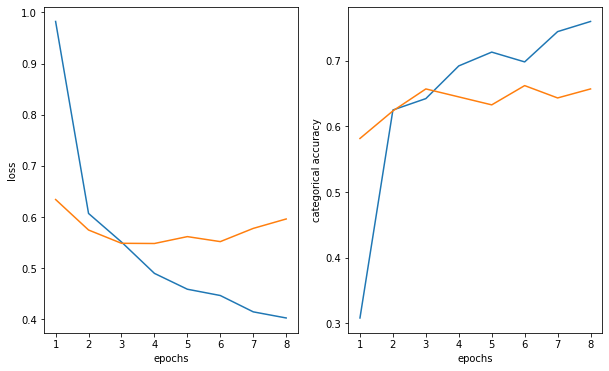

In [100]:
h = history.history
plt.figure(figsize=(10,6))
epochs = [i for i in range(1,9)]
plt.subplot(1,2,1)
plt.plot(epochs,h["loss"])
plt.plot(epochs,h["val_loss"])
plt.xlabel('epochs')
plt.ylabel('loss')

plt.subplot(1,2,2)
plt.plot(epochs,h["recall"])
plt.plot(epochs,h["val_recall"])
plt.xlabel('epochs')
plt.ylabel('categorical accuracy')

In [101]:
predictions = model.predict(test_data)
y_test_pred = np.argmax(predictions,axis=1)
cf = confusion_matrix(df_test["labels"],y_test_pred)
cf

235/235 [==============================] - 11s 43ms/step


array([[ 693,   73,   24, 1309],
       [  80, 1810,   21,   57],
       [  47,   76, 1587,   20],
       [ 654,   26,    7, 1014]], dtype=int64)

In [102]:
print(classification_report(df_test["labels"],y_test_pred))

              precision    recall  f1-score   support

           0       0.47      0.33      0.39      2099
           1       0.91      0.92      0.92      1968
           2       0.97      0.92      0.94      1730
           3       0.42      0.60      0.49      1701

    accuracy                           0.68      7498
   macro avg       0.69      0.69      0.69      7498
weighted avg       0.69      0.68      0.68      7498

